In [15]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


In [18]:
line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [17]:
twiss['qs']

0.006283858035603329

In [ ]:
list=[]

tab = line.get_table()
tab_cav = tab.rows[tab.element_type == 'Cavity']
for nn in tab_cav.name:
    #line[nn].voltage = 0
    print(line[nn].voltage)
    #list.append(list[nn].voltage)

7000000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
tab_cav

Table: 24 rows, 7 cols
name                       s element_type isthick isreplica parent_name iscollective
actcse.31632         2821.98 Cavity         False     False        None        False
actcse.31637          2826.1 Cavity         False     False        None        False
actcse.31654         2830.21 Cavity         False     False        None        False
actcsf.31672         2835.91 Cavity         False     False        None        False
actcsf.31678         2840.02 Cavity         False     False        None        False
actcsf.31695         2844.13 Cavity         False     False        None        False
acl.31735            2855.95 Cavity         False     False        None        False
actcsg.31751          2860.8 Cavity         False     False        None        False
actcsg.31758         2864.91 Cavity         False     False        None        False
actcsg.31774         2869.03 Cavity         False     False        None        False
actcsg.31780         2873.14 Cavity       

In [ ]:
from ion_properties import lead,calcium,xenon


In [ ]:
for ion in [lead,calcium]:

    # Ion properties:
    q0 = ion.q0
    mass0 = ion.mass0

    gamma = ion.gamma_cooling
    beta= ion.beta_rel
    p0c = mass0*gamma*beta #eV/c

    bunch_intensity = ion.bunch_intensity

    particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0, gamma=gamma)

    line.particle_ref=particle_ref

    nemitt = 1.5e-6 # m*rad (normalized emittance)
    sigma_z = ion.bunch_length


    emittance=nemitt/(beta*gamma)

    num_particles=int(1e3)

    particles = xp.generate_matched_gaussian_bunch(
            num_particles=num_particles,
            total_intensity_particles=bunch_intensity,
            nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
            particle_ref=particle_ref,
            line=line,        
            )

    particles0=particles.copy()
    # sigma_dp=2e-4  
    sigma_dp=np.std(particles.delta)

    ##################
    # Laser Cooler #
    ##################

    #laser-ion beam collision angle
    theta_l = 2.6*np.pi/180 # rad
    nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

    # Ion excitation energy:
    ion_excited_lifetime=ion.excited_lifetime
    hw0 = ion.hw0 # eV
    hc=constants.hbar*clight/constants.e # eV*m (ħc)
    lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

    lambda_l = lambda_0*gamma*(1 + beta*np.cos(theta_l)) # m -- laser wavelength

    # Shift laser wavelength for fast longitudinal cooling:
    #lambda_l = lambda_l*(1+1*sigma_dp) # m

    lambda_l = ion.lambda_l

    laser_frequency = clight/lambda_l # Hz
    sigma_w = 2*np.pi*laser_frequency*sigma_dp
    #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

    sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
    print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
    print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

    laser_waist_radius = 1.3e-3 #m
    laser_energy = 5e-3

    laser_x = ion.laser_x

    GF_IP = xt.PulsedLaser(
                    laser_x=laser_x,
                    laser_y=0,
                    laser_z=0,
                    
                    laser_direction_nx = 0,
                    laser_direction_ny = ny,
                    laser_direction_nz = nz,
                    laser_energy         = laser_energy, # J
                    laser_duration_sigma = sigma_t, # sec
                    laser_wavelength = lambda_l, # m
                    laser_waist_radius = laser_waist_radius, # m
                    laser_waist_shift = 0, # m
                    ion_excitation_energy = hw0, # eV
                    ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                    )

    # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
    max_time_s = 100
    int_time_s = 0.01
    T_per_turn = circumference/(clight*beta)
    num_turns = int(max_time_s/T_per_turn)
    save_interval = int(int_time_s/T_per_turn)

    # create a monitor object, to reduce holded data
    monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)


    line.discard_tracker()
    IP_index=16675   
    line.insert_element('monitor', element=monitor, index=IP_index)
    line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser

    # at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
    beta_x  =  twiss.betx[IP_index]
    beta_y  =  twiss.bety[IP_index]
    alpha_x =  twiss.alfx[IP_index]
    alpha_y =  twiss.alfy[IP_index]

    gamma_x=twiss.gamx[IP_index]
    gamma_y=twiss.gamy[IP_index]

    Dx  =  twiss.dx[IP_index]
    Dpx =  twiss.dpx[IP_index]

    Dy  =  twiss.dy[IP_index]
    Dpy =  twiss.dpy[IP_index]

    particles=particles0.copy()

    context = xo.ContextCpu(omp_num_threads=4)
    line.build_tracker(_context=context)
    line.optimize_for_tracking()

    line.track(particles, num_turns=num_turns,
                turn_by_turn_monitor=False,with_progress=True)


    # extract relevant values
    x = monitor.x[:,:,0]
    px = monitor.px[:,:,0]
    y = monitor.y[:,:,0]
    py = monitor.py[:,:,0]
    delta = monitor.delta[:,:,0]
    zeta = monitor.zeta[:,:,0]
    state = monitor.state[:,:,0]
    time = monitor.at_turn[:, 0, 0] * T_per_turn


    action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
    action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

    emittance_x_twiss=np.mean(action_x,axis=1)*gamma/2

    np.savez(f'results/{ion.name}.npz', x=x, px=px, y=y, py=py, zeta=zeta, delta=delta,
            action_x=action_x,action_y=action_y,emittance_x=emittance_x_twiss,
            state=state, time=time,s_per_turn=T_per_turn)


*** Maximum RMS bunch length 0.23410655471239558m.
... distance to target bunch length: -6.3000e-02
... distance to target bunch length: 1.6464e-01
... distance to target bunch length: 7.8245e-02
... distance to target bunch length: -3.7042e-03
... distance to target bunch length: -7.4446e-05
... distance to target bunch length: -1.7696e-08
... distance to target bunch length: 3.0957e-07
--> Bunch length: 0.0629999823037981
--> Emittance: 0.12257870084693502
Laser pulse duration sigma_t = 2.81 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Disable xdeps expressions
Replance slices with equivalent elements
Remove markers
Remove inactive multipoles
Merge consecutive multipoles
Remove redundant apertures
Remove zero length drifts
Merge consecutive drifts
Use simple bends
Use simple quadrupoles
Rebuild tracker data
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/4337400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print("beta_x:", beta_x)
print("beta_y:", beta_y)
print("alpha_x:", alpha_x)
print("alpha_y:", alpha_y)
print("gamma_x:", gamma_x)
print("gamma_y:", gamma_y)
print("Dx:", Dx)
print("Dpx:", Dpx)
print("Dy:", Dy)
print("Dpy:", Dpy)


beta_x: 54.46611023891781
beta_y: 44.39557646380093
alpha_x: -1.5456070795347345
alpha_y: 1.3225757163115908
gamma_x: 0.06222043232417969
gamma_y: 0.06192523544814771
Dx: 2.3261652157336967
Dpx: 0.09359130580265473
Dy: -0.0
Dpy: -0.0


Transverse emittance

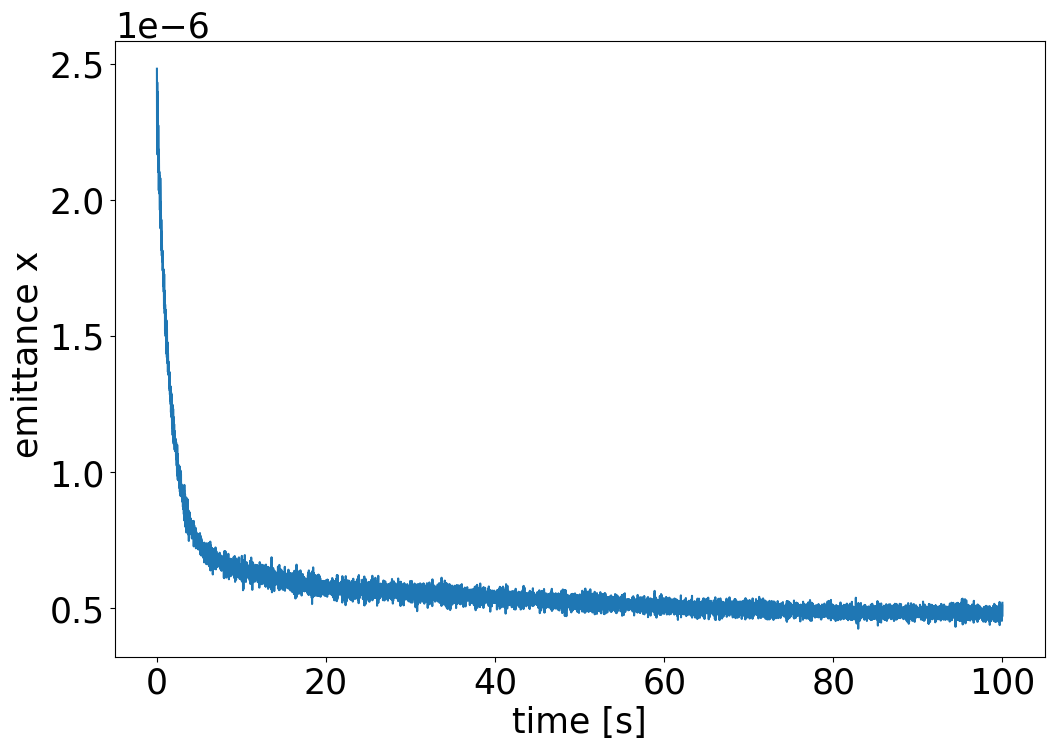

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.plot(time,emittance_x_twiss)
plt.xlabel('time [s]')
plt.ylabel('emittance x ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

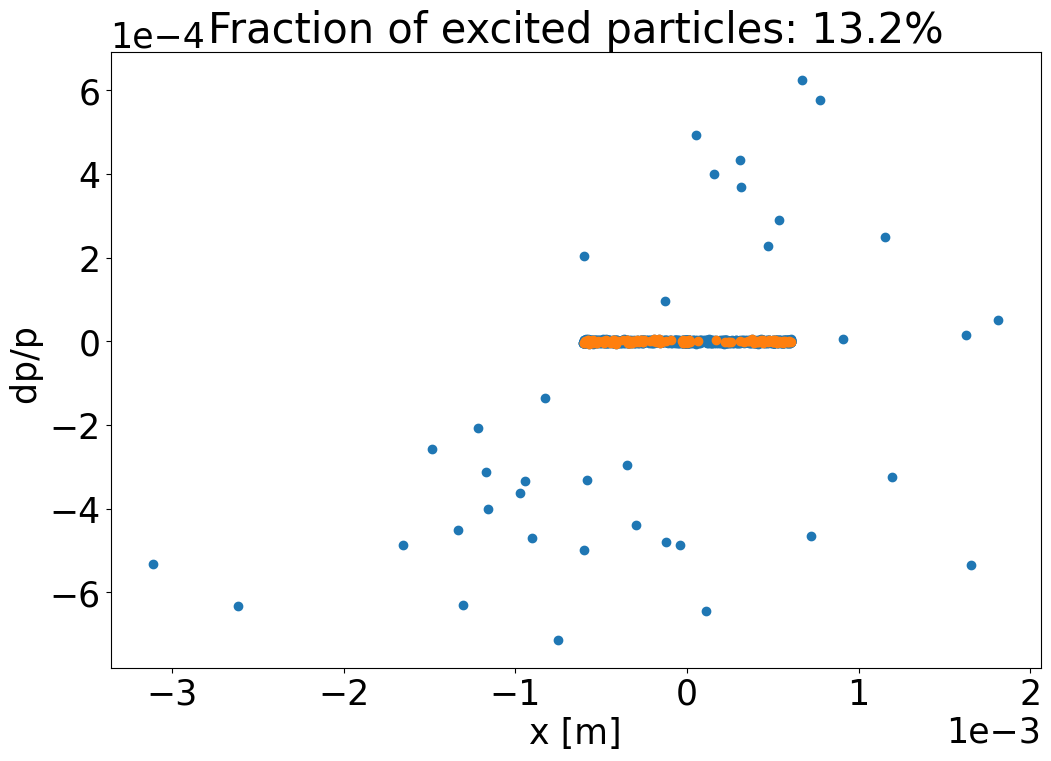

In [ ]:
excited=particles.state==2
fraction_excitation = sum(excited)/len(excited)


plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(x[-1,:],delta[-1,:])
plt.scatter(x[-1,:][excited],delta[-1,:][excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()


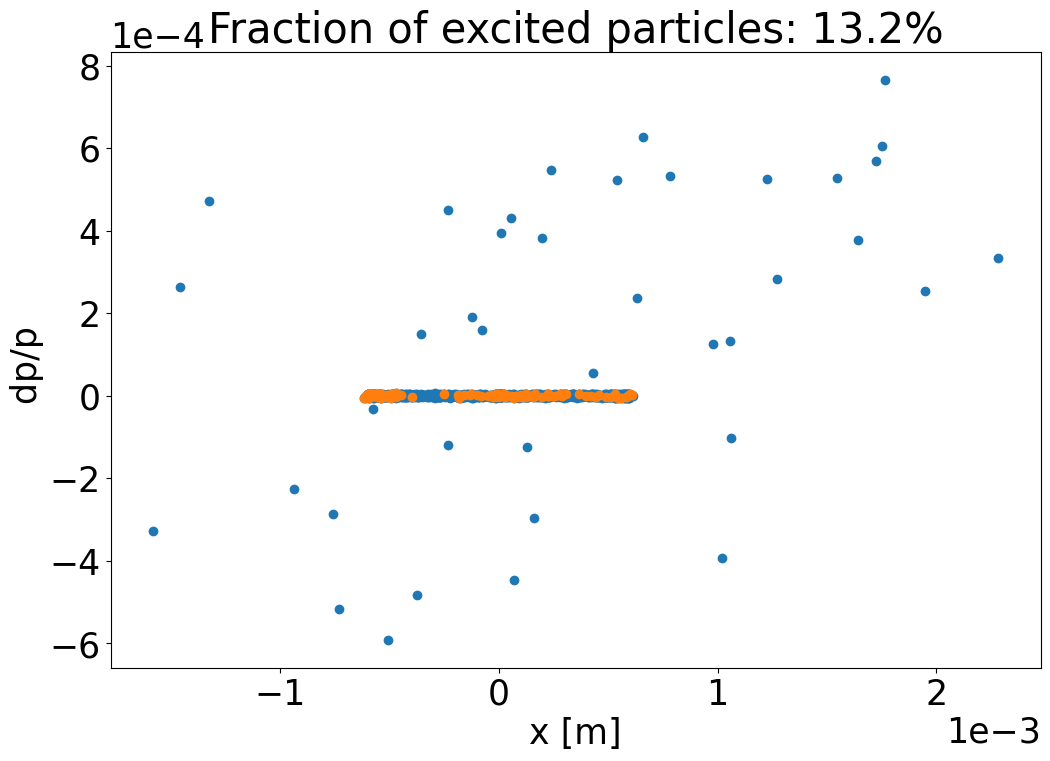

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.delta)
plt.scatter(particles.x[excited],particles.delta[excited])
plt.xlabel('x [m]')
plt.ylabel('dp/p ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

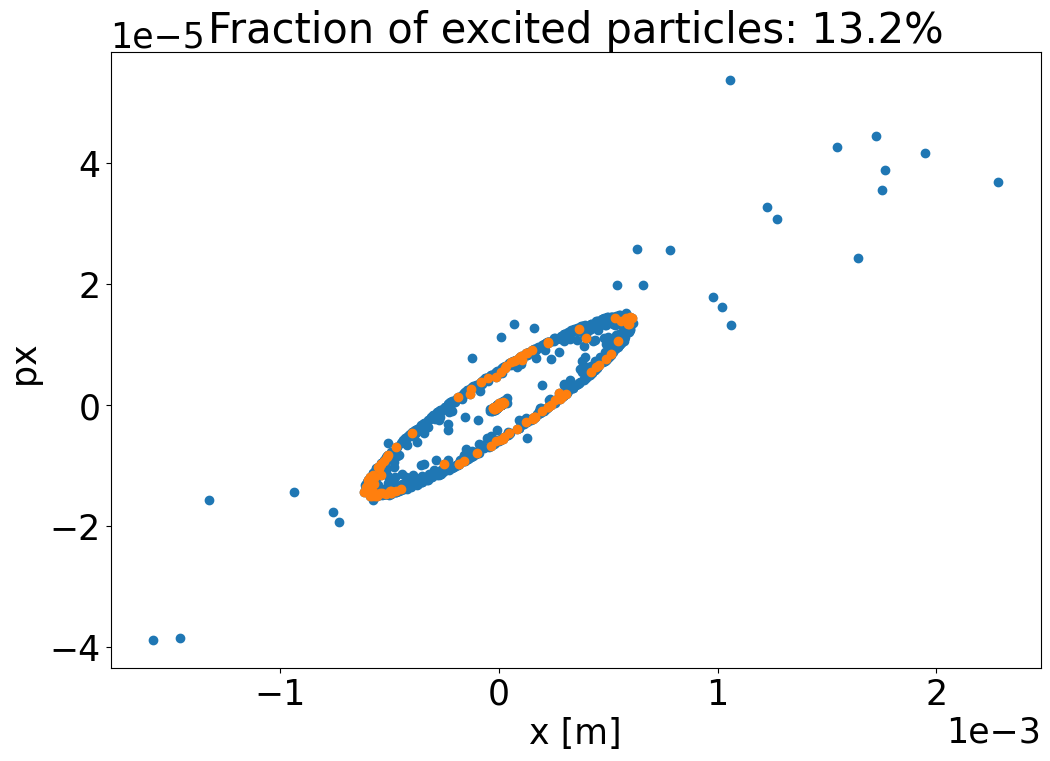

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title(f'Fraction of excited particles: {fraction_excitation*100:.3}%')
plt.scatter(particles.x,particles.px)
plt.scatter(particles.x[excited],particles.px[excited])
plt.xlabel('x [m]')
plt.ylabel('px ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()